# LJ computation in LJ units for BGY problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

# from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA
from hnc.hnc.hnc import Integral_Equation_Solver as IET

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas, Gamma, Kappa, More_TF_Zbar


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

ModuleNotFoundError: No module named 'mendeleev'


# Function for minimizing

In [2]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

@np.vectorize
def symlog(x, linthresh=1):
    if np.abs(x)<=1:
        return x
    else:
        return np.sign(x)*(1 + np.log(np.abs(x)))

@np.vectorize
def unsymlog(symx):
    if np.abs(symx)<=1:
        return symx
    else:
        return np.sign(symx)*(np.exp(np.abs(symx)-1))
    
def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    # get_sparse_csk = lambda c_s_k: unsymlog(interp1d(plasma.k_array, symlog(c_s_k).flatten())(sparse_k_array))
    # get_csk = lambda sparse_hnc_csk: unsymlog(interp1d(sparse_k_array, symlog(sparse_hnc_csk), kind='cubic')(plasma.k_array))
    get_sparse_csk = lambda c_s_k: interp1d(plasma.k_array, c_s_k.flatten())(sparse_k_array)
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.k_array)
    get_csk_matrix_from_sparse_csk =  lambda sparse_csk: get_csk(sparse_csk)
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk(sparse_c_s_k_flat).reshape(1,1,len(plasma.k_array))
        new_c_s_k_matrix = plasma.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = new_c_s_k_matrix
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = c_s_k_guess
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=1e-8)#, bounds = c_s_k_bounds)
    plasma.c_s_k_matrix = get_csk_matrix_from_sparse_csk(sol.x).reshape((1,1,len(plasma.k_array)))
    plasma.set_all_matrices_from_csk(plasma.c_s_k_matrix)
    print(sol)
    return sol


# Hard Sphere guess
def Hard_Sphere_c_r(r_array_in_rs, d_in_rs, n_in_rs, verbose=False):
    x_array = r_array_in_rs/d_in_rs
    radius_in_rs = (d_in_rs/2)
    vol_per_particle = n_in_rs
    vol_per_sphere = 4/3*π*radius_in_rs**3
    η = vol_per_sphere / vol_per_particle 
    
    if verbose:
        print(f"Packing fraction: {η}")
    λ1, λ2 = (1+2*η)**2/(1-η)**4, -(2+η)**2/(4*(1-η)**4)
    c_array_r_HS = np.where(x_array<1, -λ1 - 6*η*λ2*x_array - 0.5*η*λ1*x_array**3, 0)
    return c_array_r_HS


def best_HS(plasma, HS_param_guess = None):
    
    
    def min_function(HS_params):
        d_in_rs, n_in_rs = HS_params
        HS_c_r_matrix = Hard_Sphere_c_r(plasma.r_array, d_in_rs, n_in_rs).reshape(1,1,plasma.N_bins)
        HS_c_k_matrix = plasma.FT_r_2_k_matrix(HS_c_r_matrix)
        
        new_c_s_k_matrix = plasma.guess_c_s_k_matrix(HS_c_k_matrix)
        
        return HS_c_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    
    sol = least_squares(min_function, HS_param_guess, verbose=0, ftol=1e-8)#, bounds = c_s_k_bounds)
    return sol


In [288]:
# name = 'Argon'
# Z, A = 18, 40
# n_cc = 2.25e22#4.71e21#2.25e22
# n_AU = n_cc/cm_to_AU**3
# T0_eV = 89.5*K_to_eV#12000*K_to_eV#89.5*K_to_eV#12000*K_to_eV
# m_i = m_p*A
# Zbar0 = ThomasFermiZbar(Z, n_cc, T0_eV)
# rs = rs_from_n(n_cc)*cm_to_AU

# # Yukawa Parameters
# κ = Kappa(T0_eV*eV_to_AU, n_cc/cm_to_AU**3, Zbar0 )
# Γ = Gamma(T0_eV*eV_to_AU, n_cc/cm_to_AU**3, Zbar0 )
# print(Γ, κ, Zbar0)


# Argon from <https://doi.org/10.1063/1.479848>
@np.vectorize
def βu_LJ_126(βε, r):
    return 4 * βε * ( (1/r)**12 - (1/r)**6 ) # r is in terms of WS radius

@np.vectorize
def βu_LJ_126_CUTOFF(βε, r, cutoff):
    r_cutoff= cutoff
    return np.where(r>r_cutoff, βu_LJ_126(βε, r), βu_LJ_126(βε, r_cutoff) ) # r is in terms of WS radius

# σ_pair = 1
Tstar = 1.2
βε_pair = 1/Tstar
βu_r_LJ_func = lambda r, cutoff: βu_LJ_126_CUTOFF(βε_pair, r, cutoff )  
# Tstar = 1/βε_pair # standard LJ dimensionless number
# nstar = n_AU*σ_pair**3
nstar = 1.4#0.485#0.5925
ri_star = rs_from_n(nstar)
rs = ri_star
n_in_rs_units = nstar/ri_star**3
# print(f"T* = {Tstar}")
# print(f"n* = {nstar}")

In [289]:
n_in_rs_units, 3/(4*π)/ri_star**3, nstar

(8.210028801381322, 1.3999999999999992, 1.4)

#### Creating Initial Plasma Object

In [290]:
def LJ_plasma(cutoff, closure='hnc'): # sets IET in LJ star units
    plasma = IET(1, 1, nstar, 1, 1, oz_method='standard',
        kappa_multiscale = 0 , R_max=40.0, N_bins=5000, names=[''], closure=closure, dst_type=3)
    plasma.set_βu_matrix(  np.array([[  βu_r_LJ_func(plasma.r_array, cutoff)  ]])  )
    return plasma 




In [291]:
%%time
hnc_list = []
py_list = []

cutoff_list = np.linspace(0.4,0.4,num=1)[::-1]
for i, r_cutoff in enumerate(cutoff_list):
    hnc = LJ_plasma(r_cutoff, closure='hnc')
    py = LJ_plasma(r_cutoff, closure='py')
    
    # Get best HS fit
    HS_fit = best_HS(hnc, [1,1]).x
    print(f"\n\nHard Sphere best parameters: Radius = {HS_fit[0]*rs:0.3f} σ, Density: {HS_fit[1]/rs**3:.3f} n")
    HS_c_r_matrix = Hard_Sphere_c_r(hnc.r_array, *HS_fit).reshape(1,1,hnc.N_bins)
    HS_c_k_matrix = hnc.FT_r_2_k_matrix(HS_c_r_matrix)
    
    if i>0: 
        c_s_k_guess_py  = py.c_s_k_matrix.copy()
        c_s_k_guess_hnc = hnc.c_s_k_matrix.copy()
    else:
        c_s_k_guess_py = None#HS_c_k_matrix
        c_s_k_guess_hnc = None#HS_c_k_matrix
    
    solve_least_squares(hnc, np.linspace(hnc.k_array[0], hnc.k_array[-1], num=500), c_s_k_guess = HS_c_k_matrix )
    # solve_least_squares(hnc, np.linspace(hnc.k_array[0], hnc.k_array[-1], num=3000), c_s_k_guess = HS_c_k_matrix )
    # solve_least_squares(py, np.linspace(py.k_array[0], py.k_array[-1], num=1000), c_s_k_guess = HS_c_k_matrix )
    # solve_least_squares(py, np.linspace(py.k_array[0], py.k_array[-1], num=3000), c_s_k_guess = HS_c_k_matrix )
    hnc_list.append(hnc)
    py_list.append(py)




Hard Sphere best parameters: Radius = 0.555 σ, Density: 5.904 n
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0163e+05                                    1.74e+06    
       1              3         3.5405e+04      6.62e+04       3.54e+01       2.16e+06    
       2              5         1.1215e+04      2.42e+04       8.85e+00       8.48e+05    
       3              8         4.7638e+03      6.45e+03       5.53e-01       3.29e+04    
       4             11         3.8982e+03      8.66e+02       3.46e-02       2.53e+04    
       5             13         3.7435e+03      1.55e+02       8.65e-03       1.03e+04    
       6             14         3.6441e+03      9.94e+01       8.65e-03       7.93e+03    
       7             15         3.5269e+03      1.17e+02       1.73e-02       4.70e+03    
       8             16         3.5055e+03      2.14e+01       1.73e-02       1.37e+04    
       9             17 


KeyboardInterrupt



### Plot LJ Potentials with different cutoffs

In [292]:
from matplotlib import cm
colors = cm.get_cmap('coolwarm')(np.linspace(0,1,num=5))

fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle("Various Cutoff LJ 12-6 Potentials", fontsize=25)

hnc_label = 'HNC'
py_label  = 'PY'
for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.r_array, hnc.βu_r_matrix[0,0],color=colors[i], label=hnc_label )
        ax.plot(py.r_array, py.βu_r_matrix[0,0], '--',  color=colors[i],label=py_label )
    else:
        ax.plot(hnc.r_array, hnc.βu_r_matrix[0,0], color=colors[i])
        ax.plot(py.r_array, py.βu_r_matrix[0,0],'--',   color=colors[i])
    

ax.set_ylim(-1,1e5)
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1)

ax.set_ylabel(r"$\beta U $", fontsize=20)
ax.set_xlabel(r"$r/r_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)


/tmp/ipykernel_2856675/3725004090.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('coolwarm')(np.linspace(0,1,num=5))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7c5dfff73250> (for post_execute):
Error in callback <function flush_figures at 0x7c5db739c9d0> (for post_execute):



KeyboardInterrupt



### Direct Correlation Function

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [293]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.r_array, hnc.c_r_matrix[0,0],color=colors[i],  label=hnc_label )
        ax.plot(py.r_array, py.c_r_matrix[0,0], '--',color=colors[i], label=py_label )
    else:
        ax.plot(hnc.r_array, hnc.c_r_matrix[0,0],color=colors[i])
        ax.plot(py.r_array, py.c_r_matrix[0,0],'--', color=colors[i])

ax.plot(hnc.r_array, HS_c_r_matrix[0,0] ,'k--', label='Hard Sphere Guess')

# ax.set_ylim(-10,10)
ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$c^{(2)}$", fontsize=20)
ax.set_xlabel(r"$r/r_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7c5dfff73250> (for post_execute):
Error in callback <function flush_figures at 0x7c5db739c9d0> (for post_execute):



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7c5dfff73250> (for post_execute):


KeyboardInterrupt: 

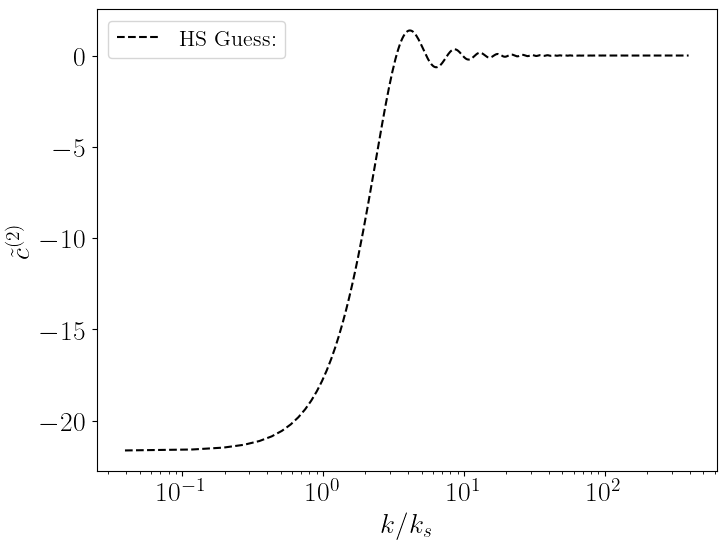

In [294]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.k_array, hnc.c_k_matrix[0,0],color=colors[i],  label=hnc_label )
        ax.plot(py.k_array, py.c_k_matrix[0,0], '--',color=colors[i], label=py_label )
    else:
        ax.plot(hnc.k_array, hnc.c_k_matrix[0,0],color=colors[i])
        ax.plot(py.k_array, py.c_k_matrix[0,0],'--', color=colors[i])

HS_c_r_matrix = Hard_Sphere_c_r(hnc.r_array, 0.8/rs, 50*3/(4*π)).reshape(1,1,hnc.N_bins)
HS_c_k_matrix = hnc.FT_r_2_k_matrix(HS_c_r_matrix)
ax.plot(hnc.k_array, HS_c_k_matrix[0,0] ,'k--', label='HS Guess: ')

# ax.set_xlim(0,50)
ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$\tilde{c}^{(2)}$", fontsize=20)
ax.set_xlabel(r"$k/k_s$", fontsize=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)

### Radial Distribution Function

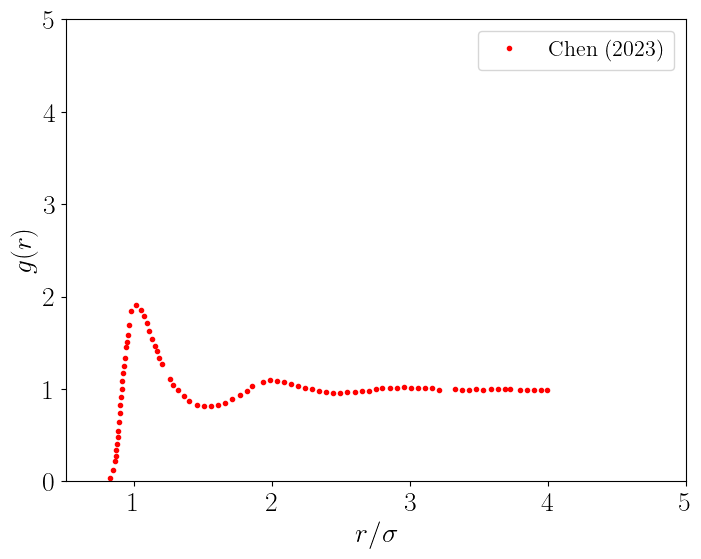

In [295]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    
    if i==0:
        ax.plot(hnc.r_array*1, hnc.h_r_matrix[0,0]+1, label=hnc_label, color=colors[i] )
        ax.plot(py.r_array*1, py.h_r_matrix[0,0]+1, '--',label=py_label, color=colors[i] )
    else:
        ax.plot(hnc.r_array*1, hnc.h_r_matrix[0,0]+1, color=colors[i])
        ax.plot(py.r_array*1, py.h_r_matrix[0,0]+1,'--', color=colors[i])

    # if i==0:
    #     ax.plot(hnc.r_array, hnc.h_r_matrix[0,0], label=hnc_label, color=colors[i] )
    #     ax.plot(py.r_array, py.h_r_matrix[0,0], '--',label=py_label, color=colors[i] )
    # else:
    #     ax.plot(hnc.r_array, hnc.h_r_matrix[0,0], color=colors[i])
    #     ax.plot(py.r_array, py.h_r_matrix[0,0],'--', color=colors[i])

data_1 = read_csv("βstar=0.2_ρstar=0.8_12-6LJ.txt", delim_whitespace=True, header=2)
data_1
ax.plot(data_1['rstar'], data_1['gii'],'r.' , label="Chen (2023)")
    
ax.set_xlim(0.5,5)
ax.set_ylim(0,5)
# ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$g(r)$", fontsize=20)
ax.set_xlabel(r"$r/\sigma$", fontsize=20)
# ax.set_yscale('symlog', linthresh=1e-6)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


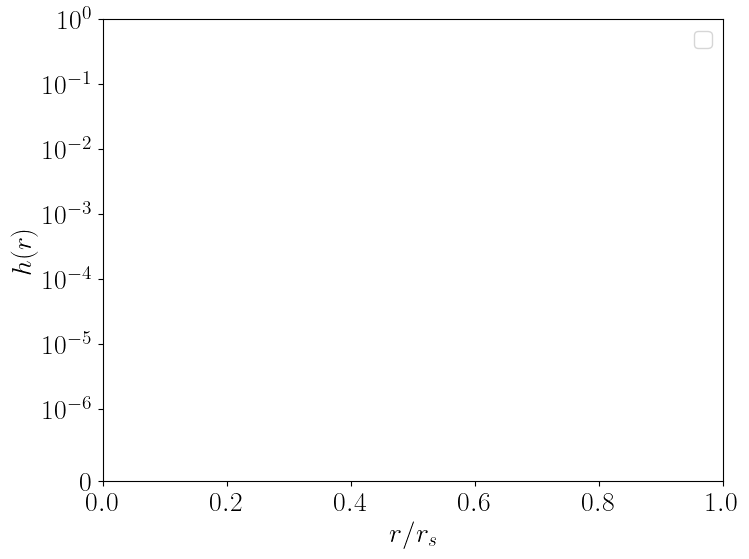

In [296]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (hnc, py) in enumerate(zip(hnc_list,py_list)):    

    if i==0:
        ax.plot(hnc.r_array, hnc.h_r_matrix[0,0], label=hnc_label, color=colors[i] )
        ax.plot(py.r_array, py.h_r_matrix[0,0], '--',label=py_label, color=colors[i] )
    else:
        ax.plot(hnc.r_array, hnc.h_r_matrix[0,0], color=colors[i])
        ax.plot(py.r_array, py.h_r_matrix[0,0],'--', color=colors[i])

# ax.set_xlim(0,5)
# ax.set_xscale('log')
# ax.set_yscale('symlog', linthresh=0.1)

ax.set_ylabel(r"$h(r)$", fontsize=20)
ax.set_xlabel(r"$r/r_s$", fontsize=20)
ax.set_yscale('symlog', linthresh=1e-6)
ax.tick_params(labelsize=20)
ax.legend(fontsize=16)

In [297]:
# output_file_name = f"LJ_PY_βε_pair={βε_pair:.3e}nstar={nstar:.3e}.dat"
# np.savetxt(output_file_name, np.array([py_list[0].r_array, py_list[0].h_r_matrix[0,0]+1, py_list[0].c_r_matrix[0,0]]).T, header=f" {'r[σ]':12} {'g_ii':12} {'c_ii':12}",comments='',fmt='%12.5e')
output_file_name = f"LJ_HNC_βε_pair={βε_pair:.3e}nstar={nstar:.3e}.dat"
np.savetxt(output_file_name, np.array([hnc_list[0].r_array, hnc_list[0].h_r_matrix[0,0]+1, py_list[0].c_r_matrix[0,0]]).T, header=f" {'r[σ]':12} {'g_ii':12} {'c_ii':12}",comments='',fmt='%12.5e')
# output_file_name

IndexError: list index out of range